# Load datasets and build one dataset by language

**Datasets:**
1. New round-2 completions (what we have labelled)
2. Old round-1 completions (what we have labelled)
3. Collected from telegram channels (we've collected channels for topics and downloaded posts)
4. Telegram provided labels from r-1 (true labels from round-1 for en and ru)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
import logging
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from torchtext import data
import re
# custom path
os.chdir('../..')


In [96]:
from src.train.predict import load_test_file

## Data prep

In [99]:
COMPLETIONS_R2 = [
    'data/raw/r-2/completions/project-1-at-2021-04-20-16-16-72cac916.json',
    'data/raw/r-2/completions/project-1-current.json',
]

COMPLETIONS_R1 = [
    'data/raw/r-1/completions/2020-02-14_completions.json',
    'data/raw/r-1/completions/2020-02-14_active_completions.json',
]

TG_DOWNLOADS = {
        'META': 'data/raw/r-1/downloads/meta.csv',
        'POSTS': 'data/raw/r-1/downloads/posts.csv',
        'TOPICS': 'data/external/telegram_channels.csv'
    }

TG_TRUE_LABELS = [
    {
        'lang_code': 'en',
        'input': 'data/external/r-1/submission1489/category_en/input.txt',
        'output': 'data/external/r-1/submission1489/category_en/tg_output.txt'
    },
    {
        'lang_code': 'ru',
        'input': 'data/external/r-1/submission1489/category_ru/input.txt',
        'output': 'data/external/r-1/submission1489/category_ru/tg_output.txt'
    },
]

PRIMARY2SECONDARY = 3

In [143]:
def calc_topic_weights(primary, secondary):
    """ create a weight dict from topics """
    total = len(primary) * PRIMARY2SECONDARY + len(secondary)
    weights = {p: PRIMARY2SECONDARY / total for p in primary}
    weights.update({s: 1 / total for s in secondary})
    return weights


def get_topics(value):
    """ return a list of topics from one string topic or multiple from a dict """
    if isinstance(value, dict):
        topics = value['choices']
    else:
        topics = [value] if value != '' else []
    return topics


def raise_non_existent(file):
    raise Exception(f'{file} does not exist')


def load_labelled_data(files):
    if len(files) == 0:
        return pd.DataFrame()
    for f in files:
        if not os.path.exists(f):
            raise_non_existent(f)
    labelled_data = [pd.read_json(c,) for c in files]
    labelled_data = pd.concat(labelled_data)
    labelled_data['secondary'].fillna('', inplace=True)
    labelled_data['primary'] = labelled_data['primary'].apply(get_topics)
    labelled_data['secondary'] = labelled_data['secondary'].apply(get_topics)
    labelled_data['category'] = labelled_data.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), axis=1)
    labelled_data.drop([
        'primary','secondary', # encoded into `category`
        'subscribers', 'counters', # for now
        'annotator', 'annotation_id', 'title_display', 'description_display', 'recent_posts_display', # from new completions
        "predictions", "score", "posts", # old completions
    ], axis=1, inplace=True, errors='ignore')
    labelled_data.info()
    return labelled_data


def prepare_text(row):
    """ extract and merge all text from a channel """
    post_texts = '\n'.join([
        post.get('text', "") 
        if isinstance(post, dict) else post
        for post in row['recent_posts']
    ])
    merged = '\n'.join([row['title'], row['description'], post_texts])
    return merged

def show_lang_stats(data):
    lang_counts = data['lang_code'].value_counts()
    sns.barplot(x=lang_counts, y=lang_counts.index);

### Load

#### New completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 265
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         276 non-null    object
 1   description   276 non-null    object
 2   recent_posts  276 non-null    object
 3   lang_code     276 non-null    object
 4   id            276 non-null    int64 
 5   category      276 non-null    object
dtypes: int64(1), object(5)
memory usage: 15.1+ KB


,title,description,recent_posts,lang_code,id,category,subset
74,اندیشه انتقادی,انتشار محتوای انتقادی و اطلاع رسانی در زمینه ه...,"[{'type': 'photo', 'text': '#سخنرانی در_گروه: ...",fa,228,"{'History': 0.375, 'Religion & Spirituality': ...",r-2_completions
22,👄حـال و هـول👅🍌,😎بهترین نیستیم،اما خوشحالیم بهترینا مارو انتخا...,"[{'type': 'photo', 'text': '😂😂 💖 #حـــــال_و...",fa,284,"{'Hobbies & Activities': 0.375, 'Humor & Memes...",r-2_completions
114,AANBA,• Наш основной чатик: @nba4ru\n• Наш чатик по ...,"[{'type': 'text', 'text': '​​Ар Джей Барретт п...",ru,182,{'Sports': 1.0},r-2_completions
260,آحہٰٰآسٰٰٓيِٰسٰٰٓ رٰآقྀ̲ـــــيةً!🥀🎼♥♾ ، ⇣,أيقنتُ بأني؛لن أتوبَك,"[{'type': 'text', 'text': '...... 🔥▂▁▁▁▁◣ @Hi...",ar,6,{'Motivation & Self-development': 1.0},r-2_completions


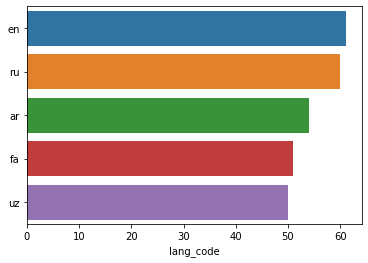

In [144]:
new_labels = load_labelled_data(COMPLETIONS_R2)
new_labels['subset'] = 'r-2_completions'

show_lang_stats(new_labels)

new_labels.sample(4)


#### Old completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 282
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   691 non-null    object
 1   lang_code     691 non-null    object
 2   recent_posts  691 non-null    object
 3   title         691 non-null    object
 4   id            691 non-null    int64 
 5   category      691 non-null    object
dtypes: int64(1), object(5)
memory usage: 37.8+ KB


,description,lang_code,recent_posts,title,id,category,subset
339,Связь с нами \n@vadim_shmotkin\nТолько оригина...,ru,[2 лота обуви! Размеры 40-44 все в очень хорош...,Вадим Шмоткин,126,"{'Fashion & Beauty': 0.75, 'Offers & Promotion...",r-1_completions
376,,ru,[КОНЦЫ В ВОДУ.\n\nА вот это уже серьезно. Тако...,Минская Семибоярщина,380,{'Politics & Incidents': 1.0},r-1_completions
175,Щэй и щизкейк. Cвязь через Twitter: @neudascha...,ru,[Бесконечный суд.\nhttps://t.me/federalpress/1...,Неудаща,387,{'Politics & Incidents': 1.0},r-1_completions


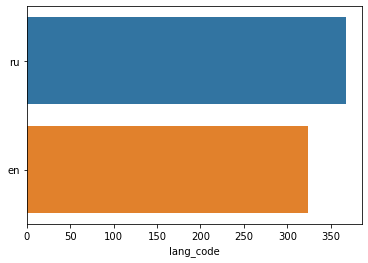

In [145]:
old_labels = load_labelled_data(COMPLETIONS_R1)
old_labels['subset'] = 'r-1_completions'


show_lang_stats(old_labels)

old_labels.sample(3)


#### Tg channel downloads

In [157]:
posts = pd.read_csv(TG_DOWNLOADS['POSTS'])
meta = pd.read_csv(TG_DOWNLOADS['META'])
topics = pd.read_csv(TG_DOWNLOADS['TOPICS'])

# clean
topics['topic [Secondary]'].fillna("", inplace=True)
posts['message'].fillna("", inplace=True)
meta['about'].fillna("", inplace=True)

# new cols
topics['username'] = topics['link'].apply(lambda x: x.split('/')[-1])
topics['lang_code'] = topics['language'].apply(lambda x: x.lower()[:2])

# rename
posts.rename({'channel':'username', 'message': 'recent_posts'}, axis=1, inplace=True)
meta.rename({'about':'description',}, axis=1, inplace=True)

# calculate topic weights
topics['primary'] = topics['topic [Primary]'].apply(lambda x: x.split(','))
topics['secondary'] = topics['topic [Secondary]'].apply(lambda x: x.split(',') if x != '' else [])
topics['category'] = topics.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), 
                               axis=1)

# group recent posts
posts = posts.groupby('username', as_index=False).agg({'recent_posts': lambda row: list(x for x in row if x != '')})


# merge
tg_downloads = topics[['username','lang_code','category']]\
            .merge(meta, on=['username'])\
            .merge(posts, on='username')
tg_downloads['subset'] = 'tg_downloads'


del tg_downloads['username']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 0 to 530
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lang_code     531 non-null    object
 1   category      531 non-null    object
 2   title         531 non-null    object
 3   description   531 non-null    object
 4   recent_posts  531 non-null    object
 5   subset        531 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


,lang_code,category,title,description,recent_posts,subset
429,ru,{'Movies': 1.0},КиноПоиск,Все самое интересное из мира кино и сериалов: ...,[Сегодня День святого Валентина — один из 365 ...,tg_downloads
108,ru,{'Job Listings': 1.0},VDHL.RU,"Вакансии в МЕДИА, в сферах дизайн, креатив, ма...",[РЕДАКТОР в Кью.\n\nЧто мы вообще делаем? Нас ...,tg_downloads
182,ru,{'Home & Architecture': 1.0},Калашников Media,Канал издания Калашников Media. Про технологи...,[Что будет с АКВ-521 зимой при температуре от ...,tg_downloads
82,ru,{'Education': 1.0},Бесплатное образование,"Публикуем анонсы бесплатных лекций, курсов и о...",[Как учиться правильно - #лекция Николая Черно...,tg_downloads


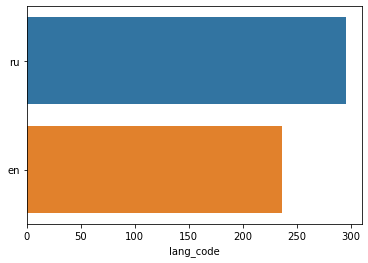

In [158]:
tg_downloads.info()

show_lang_stats(tg_downloads)

tg_downloads.sample(4)


#### Tg true labels

In [159]:
def update_dict(src_dict,dest_dict):
    src_dict.update(dest_dict)
    return src_dict

In [160]:
tg_true = []

for files in TG_TRUE_LABELS:
    inp = load_test_file(files['input'])
    out = load_test_file(files['output'])
    tg_true.extend([update_dict(i, o) for i,o in zip(inp, out)])

    
tg_true = pd.DataFrame(tg_true)

tg_true['subset'] = 'tg_true'

Loaded 14775 rows
Loaded 14775 rows
Loaded 16726 rows
Loaded 16726 rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31501 entries, 0 to 31500
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         31501 non-null  object
 1   description   31501 non-null  object
 2   recent_posts  31501 non-null  object
 3   lang_code     31501 non-null  object
 4   category      31501 non-null  object
 5   subset        31501 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


,title,description,recent_posts,lang_code,category,subset
4069,GALAXY FEEDBACK [ PROOF ],𝐀ssociated With -\n\n- @PUBG_ACCOUNT_STORES\n-...,"[Mod data vip ❤️❤️❤️, ♨️ Scammer - @YashYTNO \...",en,"{'Other': 0.5, 'Technology & Internet': 0.5}",tg_true
15738,Он&Она🍇,"Всё, о чём молчат и стесняются сказать🍌\nЛюди ...",[​​​​​​​​​На ваш баланс зачислено 56.300 руб!\...,ru,"{'Health & Medicine': 0.16666666666667, 'Psych...",tg_true
17181,🔞Your fetish (NSFW) 🔞,We don't publish hentai. Only good ecchi.\nМы ...,"[#Resident_Evil\nArtist: #logancure\n\nLink, #...",ru,"{'Erotic Content': 0.85714285714286, 'Art & De...",tg_true


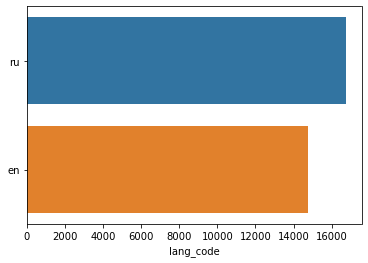

In [161]:
tg_true.info()

show_lang_stats(tg_true)

tg_true.sample(3)

## Combine and save

### concat

In [162]:
comb = pd.concat([
    new_labels,
    old_labels,
    tg_downloads,
    tg_true,

], axis=0)
comb.shape

(32999, 7)

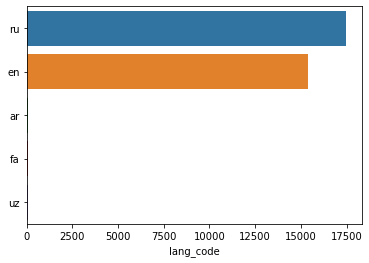

In [163]:
show_lang_stats(comb)

In [164]:
comb['subset'].value_counts()

tg_true            31501
r-1_completions      691
tg_downloads         531
r-2_completions      276
Name: subset, dtype: int64

### get raw texts

In [165]:
comb['text'] = comb.apply(prepare_text, axis=1)

### Save

In [166]:
comb.to_csv('data/interim/train_data.csv', index=False)